In [2]:
from gensim.models import Word2Vec
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer

In [63]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, ConfusionMatrixDisplay
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from collections import Counter

In [5]:
df = pd.read_csv('sms+spam+collection/SMSSpamCollection', sep='\t', header=None, names = ['spam','mail'])

In [6]:
df.head()

,spam,mail
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [14]:
le = LabelEncoder()

In [34]:
X = df['mail']
y = df['spam']

In [35]:
y_transformed = le.fit_transform(y)

In [36]:
le.classes_

array(['ham', 'spam'], dtype=object)

In [37]:
def clean(text):
    lemmatize = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(text)
    tokens = [w.lower() for w in tokens]
    tokens = [w for w in tokens if w not in stop_words and w not in string.punctuation]
    tokens = [lemmatize.lemmatize(w) for w in tokens]
    return ' '.join(tokens)

In [38]:
X_clean = X.apply(clean)

In [39]:
X_clean

0       go jurong point crazy .. available bugis n gre...
1                         ok lar ... joking wif u oni ...
2       free entry 2 wkly comp win fa cup final tkts 2...
3             u dun say early hor ... u c already say ...
4                 nah n't think go usf life around though
                              ...                        
5571                                       rofl true name
5572    limited time offer get cheap loan approved ins...
5573    limited time offer get cheap loan approved ins...
5574    limited time offer get cheap loan approved ins...
5575                                     free money offer
Name: mail, Length: 5576, dtype: object

In [40]:
model = Word2Vec(
    sentences = X,
    vector_size=100,
    min_count=10,
    window=5,
    workers=2,
    sg=1
)

In [45]:
def vectorize_mail(tokens, model):
    vectors = [model.wv[token] for token in tokens if token in model.wv]
    if len(vectors) == 0:
        return np.zeros(model.vector_size)
    return np.mean(vectors, axis=0)

In [46]:
X = np.array([vectorize_mail(email, model) for email in X_clean])

X

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X,y_transformed, test_size=0.2, random_state=42)

In [58]:
smote = SMOTE(random_state=42)

In [59]:
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [64]:
Counter(y_train_smote)

Counter({0: 3872, 1: 3872})

In [65]:
param_grid = {
    'learning_rate':[0.1,0.4],
    'n_estimators':[500,1000],
    'max_depth':[7,10],
    'min_samples_split':[2,3],
    'subsample':[0.8],
    'reg_alpha':[0.1,0.2],
    'reg_lambda':[0.1,0.2],
    'gamma':[1]
}

In [66]:
XG_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state=42)

In [67]:
gcv = GridSearchCV(XG_model, param_grid, scoring='precision', cv=5, n_jobs=-1)

In [68]:
gcv.fit(X_train_smote, y_train_smote)

C:\Users\sruji\anaconda3\envs\word2vec-env\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:12:58] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     feature_weights=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraint...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'gamma': [1], 'learning_rate': [0.1, 0.4],
                         'max_depth': [7, 10], 'min_samples_split': [2, 3],
                         'n_estimators': [500, 1000], 'reg_alpha': [0.1, 0.2],
                         'reg_lambda': [0.1, 0.2], 'subsample': [0.8]},
             scoring='precision')

In [69]:
gcv.best_params_

{'gamma': 1,
 'learning_rate': 0.1,
 'max_depth': 10,
 'min_samples_split': 2,
 'n_estimators': 1000,
 'reg_alpha': 0.1,
 'reg_lambda': 0.1,
 'subsample': 0.8}

In [72]:
best_model= gcv.best_estimator_

In [73]:
y_pred = best_model.predict(X_test)

In [74]:
a_score = accuracy_score(y_test, y_pred)

In [75]:
a_score

0.9802867383512545

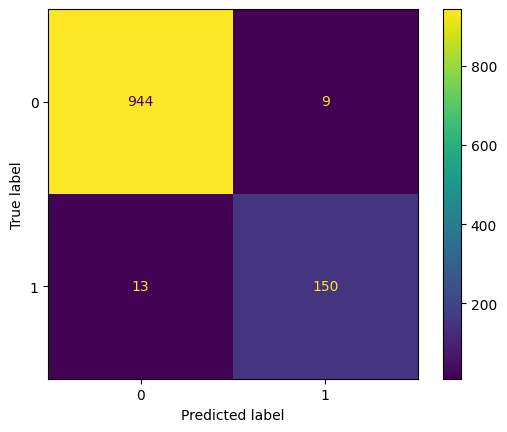

In [76]:
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred))
disp.plot()

In [77]:
def categorize(msg):
    clear_msg = clean(msg)
    X = np.array([vectorize_mail(clear_msg, model)])
    prediction = best_model.predict(X)
    classify = le.inverse_transform(prediction)
    return classify

In [78]:
msg = 'Free money offer just for you!'

In [79]:
categorize(msg)

array(['spam'], dtype=object)